In [2]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display_javascript

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize
DECILES = list(np.arange(0.1, 1.0, 0.1))

store = load_store()
g = games = load_games()

In this post, I'll be taking a step back and doing some analysis at the level of players of DCSS, rather than individual games. How many players do we have?

In [13]:
print "{:,} distinct players among {:,} games".format(
    g['pid'].unique().shape[0], len(g)
)
print
print "Distribution of games played per player..."
print
print g.groupby('pid').size().describe()

26,004 distinct players among 1,326,162 games

Distribution of games played per player...

count    26004.000000
mean        50.998385
std        201.641369
min          1.000000
25%          1.000000
50%          3.000000
75%         20.000000
max       8170.000000
dtype: float64


The "average" player has 50 games, though this statistic is pretty misleading. A majority of players can count their games on one hand. 

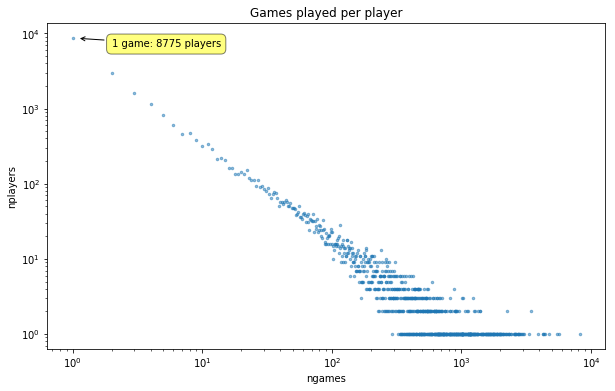

In [5]:
count_counts = g.groupby('pid').size().value_counts().to_frame('nplayers')
count_counts['ngames'] = count_counts.index
fig, ax = plt.subplots(figsize=FS)
ax.scatter(count_counts['ngames'], count_counts['nplayers'], marker='.', s=25, alpha=.5)
onegame = count_counts.loc[1]['nplayers']
ax.annotate("1 game: {} players".format(onegame), 
            xy=(1.1, onegame*.98), xytext=(2, onegame*.75),
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
           )
ax.set_xlabel('ngames')
ax.set_ylabel('nplayers')
ax.set_title("Games played per player")
ax.loglog();

A straight line on a log-log plot. Looks like some kind of power-law distribution. 

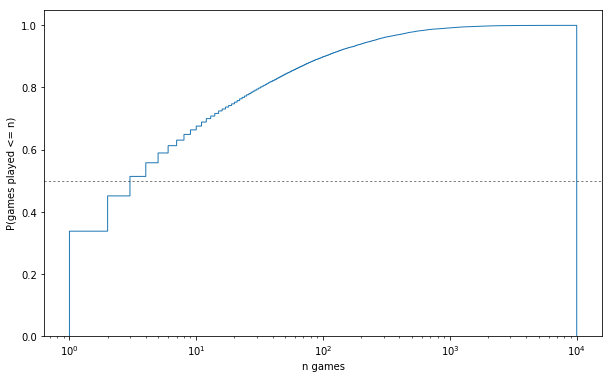

In [14]:
fig, ax = plt.subplots(figsize=FS)
counts = g.groupby('pid').size().values
n, bins, patches = ax.hist(counts, 
                           np.arange(1, 10**4),
                           #np.logspace(0, 4, 150),
       normed=1, histtype='step', cumulative=1
)
midpoint = (n >= .5).argmax()
midpct = 100 * n[midpoint]
ax.set_xscale('log');
ax.axhline(y=.5, color='black', linestyle=':', linewidth=.5);
ax.set_xlabel('n games')
ax.set_ylabel('P(games played <= n)');

In [15]:
print '{:.1f}% of players have <= {} games'.format(
    midpct, midpoint+1)

51.4% of players have <= 3 games


What about the distribution of wins across players?

In [3]:
gpp = games_per_pid = g.groupby('pid').size()
wpp = wins_per_pid = g.groupby('pid')['won'].sum()
wpp = wins_per_pid
print "{:,} / {:,} players have won at least one game".format(
    (wpp > 0).sum(), len(wpp)
)

2,111 / 26,004 players have won at least one game


That statistic certainly speaks to DCSS's difficulty. **>90%** of players have never won a game.

In [6]:
print "Do winners account for more games?"
winpids = wpp.where(lambda wins: wins > 0).dropna().index
print "Avg. number of games played by...\n\twinners: {:.1f}\n\tnon-winners: {:.1f}".format(
    g[g['pid'].isin(winpids)].groupby('pid').size().mean(),
    g[~g['pid'].isin(winpids)].groupby('pid').size().mean(),
)
winnergames = g['pid'].isin(winpids).sum()
print "{:,} out of {:,} games ({:.1f}%) were played by players who have won a game".format(
    winnergames, len(g), 100*winnergames/len(g),
)

Do winners account for more games?
Avg. number of games played by...
	winners: 305.3
	non-winners: 28.5
644,434 out of 1,326,162 games (48.6%) were played by players who have won a game


In [12]:
gameticks = [1, 2, 5, 10, 25, 50, 100, 250, 
                          500, 1000, 2000, 4000,
                          10000]
winticks = [1, 2, 5, 10, 25, 50, 100]
def scatter_games_v_wins(minwins=0, jitter=False):
    fig, ax = plt.subplots(figsize=FS)
    wins = wpp[wpp >= minwins]
    winjitter = 0
    if jitter:
        winjitter = (np.random.rand(len(wins)) - .5) * .55
    ax.scatter(gpp.loc[wins.index], wins.values + winjitter,
              alpha=.1,
              )
    ax.set_yscale('symlog' if minwins==0 else 'log')
    ax.set_xscale('log')
    ax.set_xticks(gameticks)
    ax.set_yticks(winticks);
    ax.set_xticklabels([str(i) for i in gameticks])
    ax.set_yticklabels([str(i) for i in winticks]);
    ax.set_xlabel('Games')
    ax.set_ylabel('Wins')
    ax.set_title("Games vs. wins per player")
    return ax

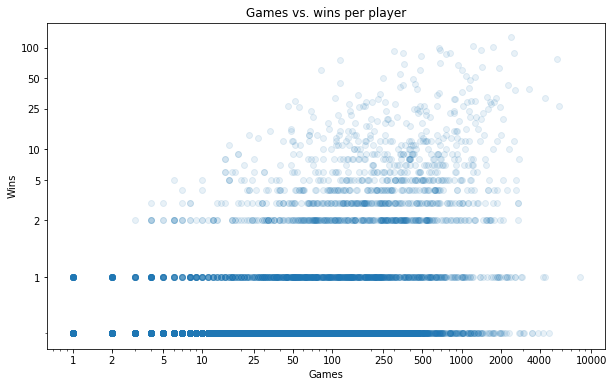

In [13]:
scatter_games_v_wins();

Here I'm placing a dot for each player, according to their number of games played and number of wins (still on a log-log scale). It's hard to get a sense of what's going on in those stripes that form at 0/1/2 wins. We can maybe get a better sense of the density by randomly jittering each point in the y direction:

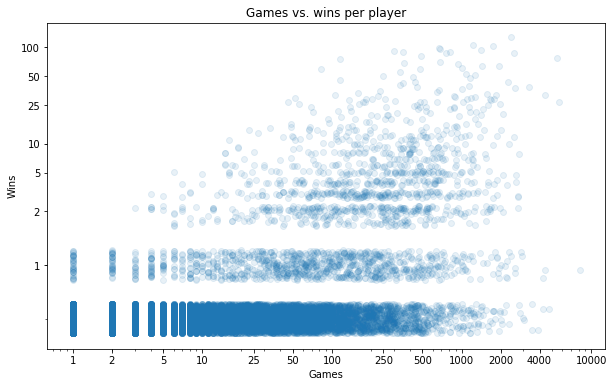

In [14]:
scatter_games_v_wins(jitter=1);

We already knew there were a *lot* of players with 0 wins (more than 90% of all players). But it's interesting to see that this isn't just a result of having lots of players who have played a tiny number of games. There are many people who have played 100+ games without a win.

Let's turn our attention to just the players with at least 1 win.

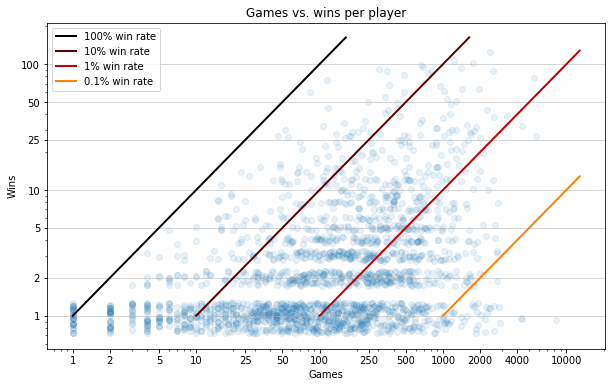

In [23]:
ax = scatter_games_v_wins(minwins=1, jitter=1)
ax.grid(axis='y', lw=.5);
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ymin = 1
cmap = plt.get_cmap('gist_heat')
winrate_lines = [.001, .01, .1, 1.0]
for i, wr in enumerate(reversed(winrate_lines)):
    p1 = [ymin/wr, ymin]
    if xmax*wr <= ymax:
        p2 = [xmax, xmax*wr]
    else:
        p2 = [ymax/wr, ymax]
    xs, ys = zip(p1, p2)
    ax.plot(xs,
            ys,
            label=('{}% win rate'.format(int(wr*100)) if wr >= .01
                   else '{:.1f}% win rate'.format(wr*100)),
            color=cmap(i/len(winrate_lines)),
            linewidth=2, linestyle='-',
    )
ax.legend();

Eyeballing the diagonal guides, it seems like the greatest density is around the 1% win rate, with the vast majority falling somewhere between 0.1 and 10%.

There appear to be a fair number of players with a 100% win rate over 1 game.

In [21]:
perfect = gpp == wpp
print "{} players have a perfect record (avg. number of games played = {})".format(
    perfect.sum(), gpp[perfect].mean(),
)

37 players have a perfect record (avg. number of games played = 1.0)


Far more impressive are those few dots with a >50% win rate over 50+ games.

In [21]:
wrpp = g[g['pid'].isin(gpp[gpp >= 50].index)].groupby('pid')['won'].mean().rename('winrate')
tops = wrpp.sort_values(ascending=0).head(3)
players = store['players']
print pd.concat([
    players.loc[tops.index].rename('name'),
    wpp.loc[tops.index].rename('wins').astype(int),
    gpp.loc[tops.index].rename('games'),
    tops.round(2),     
], axis=1)

                  name  wins  games  winrate
pid                                         
17003       jumbajumba    60     83     0.72
6203   makemeasandwich    75    115     0.65
8250          hellmonk    30     52     0.58


You go, [jumbajumba](http://crawl.akrasiac.org/scoring/players/jumbajumba.html)!

## Separating the wheat from the chaff

It'd be really useful if we could assign a score to each player that reflected how good they are at the game.

### Motivation

Let's say we have some hypothesis about some gameplay decision, like...

- Abyssal is usually a safer third rune than Silver
- Maces are the best weapon type for Gargoyle Fighters
- The best use of scrolls of acquirement is to acquire food

One simple way to evaluate these kinds of claims is by looking at the games where $choice occurred (e.g. the games where the player went for abyssal as their third rune, or GrFi games where the player focused on maces), and seeing how many of them ended in victory, compared to games where the alternative occurred. 

The problem with this approach is that it uses a signal (wins) which is sparse and noisy.

- **Sparse** because DCSS is a hard game. Let's say we're investigating the claim that axes are the best weapon type for Gargoyle Fighters. Fortunately, GrFi is the third most popular combo in the dataset, with 30,000 games. But of those 30k games, there are only 400 wins. If half of those gargoyles used maces, and choosing maces increased the chance to win by 5%, the expected difference between mace-users and other-weapon-users is just 20 wins, which is well within measurement error.
- **Noisy** because games involve a lot of decisions (and randomness). The effect of any one decision on whether that game is won is going to be pretty small. 

In some cases, we might find it easier to **just ask what skilled players do**. "How often do strong players take the Abyssal rune as their third?" "Do strong players specialize in maces more often when playing GrFis?"

By assigning a varied range of 'skill' scores to players, we no longer have the problem of sparsity. Even if games A and B were both lost, we can say that A was 'better' if it was played by a player with a 5% win rate, and B was played by someone with a 0.5% win rate.

This should also be a less noisy signal. The effect of any given decision on whether a game is won may be very inconsistent, but we can expect players to be pretty consistent in their decision-making. 

The downside is that we're measuring the goodness of these choices indirectly, relying on the assumption that good players make good decisions. If the competitive community agreed on some common wisdom that turned out to be counterproductive, this approach would fail to identify it as such.

(Also, knowing whether a particular behaviour is strongly associated with experienced/inexperienced players is interesting in its own right, even if we're not trying to make any claims about a causal effect on winning.)

### Sorting by win rate

The simplest metric would just be the raw win rate per player: `nwins / ngames`.

In [26]:
print "Distribution of win rates (as %) across players...\n"
wrpp = g.groupby('pid')['won'].mean().rename('winrate')
print (100*wrpp).describe([.5, .9, .925, .95, .975, .99, .995])

Distribution of win rates (as %) across players...

count    26004.000000
mean         0.605308
std          5.030780
min          0.000000
50%          0.000000
90%          0.000000
92.5%        0.236466
95%          1.265480
97.5%        4.166125
99%         14.574405
99.5%       31.988750
max        100.000000
Name: winrate, dtype: float64


This is still a pretty sparse signal - over 90% of players get assigned the same score of 0.

Intuitively, it seems like there should be room for differentiation among those non-winners. Player A, with 0 wins out of 300 games should probably be ranked lower than B with 0 wins out of 2 games. We have pretty strong evidence that A has a low winrate. But B's record is not at all inconsistent with them having, say, a 10% winrate.

Similarly, a player with 30 wins out of 100 games should probably rank higher than a player with 1 win out of 1 game, even though the latter has a much higher nominal win rate. As it is, once our winrates are non-zero, they shoot up exponentially through the last 7.5%. The players with one or two wins out of a small number of games are inflating the top end.

This is basically the same problem as [sorting starred product reviews](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html). The bread machine with a single 5-star review should probably not be ranked higher than the one with 100 reviews averaging 4.9 stars.

### Getting Bayesian

We're trying to estimate the "true" win rate $wr$ (i.e. the value that player's win rate would converge on if we sat them down and made them play DCSS for eternity), given the evidence that they've won $w$ out of $n$ games.

Bayes' rule for conditional probabilities gives the expression

$$P(wr \mid w,n) = \frac{P(w,n \mid wr) \cdot P(wr)} {P(w,n)}$$

We want to find the most probable win rate, i.e. the one that maximizes this expression. Our choice of $wr$ has no effect on $P(w,n)$, the probability of the observed number of wins and games, so we can drop that term, leaving us to maximize:

$$P(wr \mid w,n) \propto P(w,n \mid wr) \cdot P(wr)$$

If we say that all win rates are equally likely, we can also drop $P(wr)$. Choosing $wr$ that maximizes $P(w,n \mid wr)$ is easy. It's just $w/n$. For example, the coin that is most likely to produce 4 heads out of 5 flips is the one with $P(heads) = .8$.

But now we're back where we started. Where did we go wrong?

### Incorporating prior knowledge

Are all win rates equally likely? Of course not. For example, we know that, among players with a non-trivial number of games, win rates above 10% are exceedingly rare. 

If we knew that most coins were fair, we would probably just guess that our coin has $P(heads) = .5$ even after seeing 4 heads out of 5 flips.

I'm going to add a couple parameters to our earlier expression that describe our prior beliefs about where winrates fall:

$$P(wr \mid w,n,\pi,C) \propto P(w,n \mid wr) \cdot P(wr \mid \pi,C)$$

$\pi$ is going to represent a typical win rate, and $C$ is a scaling factor that controls the strength of our prior belief.

I won't go through the derivation here (check out [this wiki article](https://en.wikipedia.org/wiki/Conjugate_prior#Example) if you're interested), but it turns out that a reasonable model under this parameterization leads to a posterior that is maximized by:

$$ wr = \frac{C \pi + w} {C + n} $$

### Parameterizing our prior

A simple way to think about this transformation is that we're padding our calculated win rate with $C$ additional games, of which $C \pi$ are wins.

An obvious value for $\pi$ is just the win rate over all games in the dataset (0.74%).

$C$ is a bit more subtle. For now, I'm going to wave my hands and say that 30 is a pretty good number. If you're interested in the nitty gritty of how I got there, check out the appendix at the end.

Let's see some examples of what this smoothing looks like.

In [7]:
wr_prior = g['won'].mean()
# Controls the strength of the smoothing
C = 30
def smooth(wins, games):
    return 100 * (
        (wins + (C * wr_prior))
        /
        (C + games)
    )

wg = [
    (0, 1), (1, 1), (0, 10), (0, 50), (1, 500), (1, 10), (5, 50), (20, 200),
]
print "Smoothed winrate examples (C={}, pi={:.2f}%)...\n".format(C, wr_prior*100)
for (wi, ga) in wg:
    print "{} wins / {} games: {:.2f}%".format(wi, ga, smooth(wi, ga))

Smoothed winrate examples (C=30, pi=0.74%)...

0 wins / 1 games: 0.72%
1 wins / 1 games: 3.94%
0 wins / 10 games: 0.55%
0 wins / 50 games: 0.28%
1 wins / 500 games: 0.23%
1 wins / 10 games: 3.05%
5 wins / 50 games: 6.53%
20 wins / 200 games: 8.79%


C=30 basically means that a player with 30 games will be assigned a score halfway between their raw winrate and the overall average. If you have 270 games, 90% of your score will come from your actual winrate, and 10% from our padding. With just 1 game, your score will be much closer to the overall average than to your raw win rate of 0% or 100%.

Let's see what this smoothing looks like in practice when applied to the players in our dataset.

In [4]:
import winrate
g['raw winrate'] = g.groupby('pid')['won'].mean().loc[g['pid']].values
g['wr'] = winrate.smoothed_winrate(g)
print "Distribution of raw/smoothed winrates over players...\n"
print (100*g.groupby('pid')[['raw winrate', 'wr']].mean()).rename(columns={'wr': 'smoothed winrate'})\
    .describe([.1, .25, .5, .75, .9, .95, .975, .99, .995])

Distribution of raw/smoothed winrates over players...

        raw winrate  smoothed winrate
count  26004.000000      26004.000000
mean       0.605308          0.736694
std        5.030780          1.721895
min        0.000000          0.001564
10%        0.000000          0.119250
25%        0.000000          0.352072
50%        0.000000          0.616126
75%        0.000000          0.672138
90%        0.000000          0.672138
95%        1.265480          1.234408
97.5%      4.166125          3.498974
99%       14.574405          7.876029
99.5%     31.988750         10.216228
max      100.000000         64.595629


This looks pretty good. There's a lot of variation now in the lower 90%, and the top end has been dampened (the highest smoothed winrate is 65%, compared to 100% in the unsmoothed version).

But wait, the mean has gone up from 0.6% to 0.7%. Are we guilty of grade inflation?

When we look at the mean winrate across players, we're taking an averages of averages, which is misleading because of the amount of variation in number of games played per player. If we look at the distribution over all *games* (assigning to each game the corresponding player's winrate), we get...

In [169]:
print (100*g[['raw winrate', 'wr']]).rename(columns={'wr': 'smoothed winrate'})\
    .describe([.1, .25, .5, .75, .9, .95, .975, .99, .995])

        raw winrate  smoothed winrate
count  1.326162e+06      1.326162e+06
mean   7.393516e-01      7.398727e-01
std    2.514039e+00      2.132121e+00
min    0.000000e+00      1.564103e-03
10%    0.000000e+00      8.940164e-03
25%    0.000000e+00      2.718204e-02
50%    0.000000e+00      1.320271e-01
75%    5.464481e-01      5.870224e-01
90%    1.743836e+00      1.727191e+00
95%    3.396226e+00      3.222991e+00
97.5%  5.714286e+00      5.289433e+00
99%    1.086420e+01      1.025598e+01
99.5%  1.508380e+01      1.432483e+01
max    1.000000e+02      6.459563e+01


So the average win rate weighted by number of games played has only increased by a negligible 0.005%. Almost 1/3 of players in our dataset have a record of 0/1. Increasing their winrate from 0 to 0.72% has a big impact on the average win rate per player, but they account for less than 1% of games.

## Caveats

I think this is a pretty reasonable solution, but there are some issues worth mentioning...

### Players grow

My model assumes that players have a static win rate, and each game played is an independent Bernoulli trial. Baloney! 

Players probably tend to improve with experience. A more principled approach might assign players a series of win rates, by applying a moving window to their game history, with the contribution of a game exponentially decaying with its distance from the focal game.

### Not all wins are equal

The Crawl community seems to value versatility. The prized titles of ["great/greater player"](https://crawl.develz.org/tavern/viewtopic.php?f=5&t=20762) have nothing to do with winrate - they're earned by winning a game with each species/background. Someone with a 5% win rate playing nothing but Minotaur Fighters should probably be ranked behind a player with a 4.5% win rate who plays all species/bg combos in equal proportion.

One way to account for this would be to assign a different prior to each game according to the chosen species and background (e.g. the win rate over all games is 0.74%, but for just Minotaur Fighter games, it's 1.17%). This could even take into account the game version. The effect of a given game on a player's score would scale with how surprised we are at the outcome. A MuBe win might be worth more points than a MiFi win. And a MuBe loss might have a less negative effect on a player's score than a MiFi loss.

We also don't give any extra credit for wins with more than 3 runes. Accounting for this would be much trickier. How much harder is a 15-rune MiFi run than a 3-runer? To answer that, we'd need to know what % of 15/3 rune MiFi attempts succeeded. But we can't measure that directly, because player's don't register the number of runes they intend to get at the beginning of the game.

### Not all losses are equal

Sometimes players aren't trying to win. Someone might create a throwaway character to test something, then splat it when they're done. This shouldn't count against their skill. (My analysis excludes games that were quit at level 1, but a test character might die after that, or the player might just let themselves get clubbed to death by a kobold rather than quitting with ctrl+Q). A player may also quit just out of boredom.

We're also not giving any partial credit. A character that dies to an Orb of Fire in Zot has the same effect on a player's score as one that dies to a gnoll on D:3. Given an arbitrary amount of games, this wouldn't matter. But with a small number of games, getting more signal from the losses would help us smooth out our estimate. However, there's no clear way to measure partial progress, and we might philosophically object to the possibility of giving a higher score to player A who dies at Vaults:5 every game than to player B who wins every 50th game, but splats the other 49 before the temple.

## Fin

Want to see an example of using this smoothed winrate data? Check out my post on [testing 4 Crawl newbie traps](/blog/dcss_newbie_traps).

# Appendix: Choosing parameters for a win rate prior

I described our prior on the distribution of win rates using the parameters $\pi$ and $C$, where $C$ is the number of "pseudo-games" we're adding to the actual observed games for a player, and $\pi$ is the win rate for those pseudo-games.

I chose $\pi = .0074$ and $C = 30$, meaning that we calculate each player's win rate as if we saw them play 30 additional games, of which 0.222 were wins and 29.778 were losses.

The choice of $\pi$ was easy - it's just the overall average win rate. $C$ is more complicated. How did I get to 30?

What I said above about pseudo-counts is equivalent to saying that our prior on win rates is a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with $\alpha = \pi C$ and $\beta = (1-\pi)C$. 

The Beta distribution assigns probabilities to values in the range [0, 1], which can themselves be thought of as probabilities. It's like a distribution over (Bernoulli) distributions (a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior_distribution) if you want to get fancy). In this case, the probabilities we're assigning probabilities to are *win rates*.

One way we can evaluate our prior is just graphing it against our observed win rates. What we're trying to model is the distribution of "true" win rates across players, and unfortunately we can't sample a single value from that distribution. But, we can treat our observed win rates as noisy samples from that distribution - and by only drawing from players with at least, say, 100 games, we can limit their noisiness.

Let's start by plotting a Beta distribution with $C=1$ - i.e. just a single pseudo-event.

In [79]:
from scipy.stats import beta
thresh = 100
pids = gpp[gpp >= thresh].index
foo = g[g['pid'].isin(pids)].groupby('pid')['raw winrate'].mean()

In [61]:
C = 1
a=wr_prior*C
b=(1-wr_prior)*C
mult = 5
B = beta.rvs(a=a, b=b, size=len(foo)*mult)
print ("Plotting cumulative density of Beta distribution with a={:.3f} b={:.2f} vs. "
       "raw win rates for {} players having at least {} games".format(a, b, len(foo), thresh))

Plotting cumulative density of Beta distribution with a=0.007 b=0.99 vs. raw win rates for 2644 players having at least 100 games


In [72]:
def plot_winrates(C=10, prior=(0,0), ax=None):
    a=wr_prior*C + prior[0]
    b=(1-wr_prior)*C + prior[0]
    mult = 1
    B = beta.rvs(a=a, b=b, size=len(foo)*mult)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    order = 1
    y1 = np.arange(len(foo)) / len(foo)
    y2 = np.arange(len(foo)*mult) / (len(foo)*mult)
    ax.step(np.sort(foo.values)[::order], y1, label='actual', alpha=.5)
    ax.step(np.sort(B)[::order], y2, label='theoretical', alpha=.5)
    ax.vlines(wr_prior, *ax.get_ylim(), label='prior winrate', linestyle="--", lw=.5)
    ax.hlines(0.5, *ax.get_xlim(), label='median', linestyle=":", lw=.5)
    ax.legend()
    ax.set_ylabel('cumulative density')
    return ax

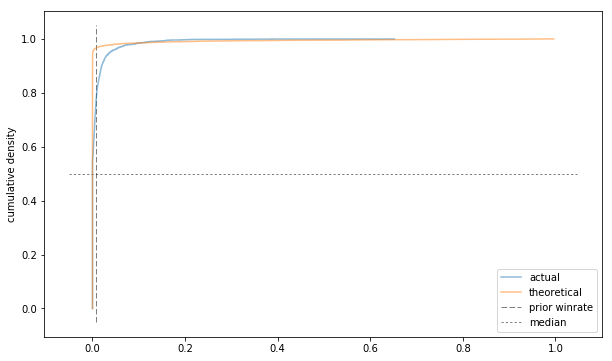

In [62]:
ax = plot_winrates(C=1)
ax.set_xlabel('winrate');

It's a bit hard to tell what's going on here because so much of the action is happening at the far left (as it should - we know that win rates over 10% are exceedingly rare).

Here's the same thing with a log-ish x scale. (To avoid pathological behaviour as x goes to 0, the scale is linear for very small x.)

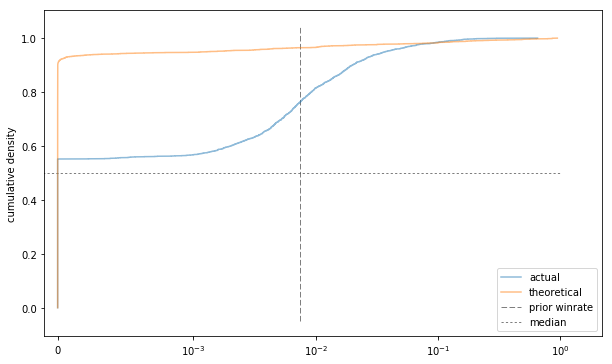

In [70]:
ax = plot_winrates(C=1);
xlin = 10**-3
ax.set_xscale('symlog', linthreshx=xlin);
ax.set_xlim(left=-10e-5);
ax.legend(loc=4);
ax.set_xlabel('winrate');

Well that's not very good at all. To understand what's going on here, it helps to understand the limiting behaviour of the Beta distribution. There are three parameterizations of the distribution that are commonly used as 'uninformative priors':

- Bayes' prior, $Beta(1,1)$ assigns equal probability to all values in [0,1]
- Jeffreys' prior, $Beta(1/2,1/2)$ is a U-shaped curve, assigning the most probability mass around 0 and 1, and the least at 0.5.
- Haldanes' prior, $Beta(0,0)$ says P(0) = P(1) = .5. All other values are assigned a probability of 0.

(More details + diagrams on [wikipedia](https://en.wikipedia.org/wiki/Beta_distribution#Bayes.27_prior_probability_.28Beta.281.2C1.29.29)).

We're implicitly starting from Haldanes' prior. If C is small, meaning that the strength of our belief that our winrates are around .74% is weak, then our distribution will more closely resemble $Beta(0,0)$, assigning more mass to the extremes.

In this case, because $\beta \gg \alpha$, we get an asymmetrical take on Haldanes', with the bulk of the mass concentrated at 0. (However, we still get a few samples close to 1, that are higher than any of the observed winrates.)

What if we set a very large value of C, like 1000?

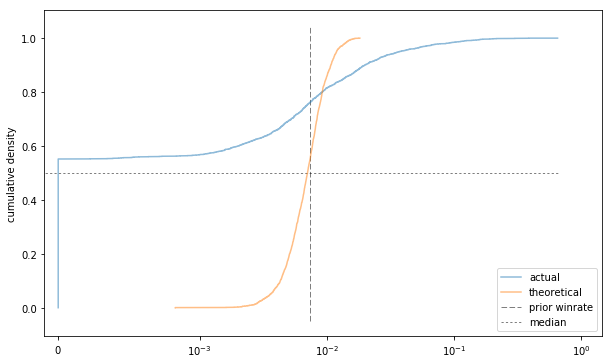

In [71]:
ax = plot_winrates(C=1000);
xlin = 10**-3
ax.set_xscale('symlog', linthreshx=xlin);
ax.set_xlim(left=-10e-5);
ax.legend(loc=4);
ax.set_xlabel('winrate');

This porridge is too cold!

We're very confident in our 0.74% win rate this time, so we rarely pick any probabilities that stray too far from it. Unlike the previous sample (and the observed data), the sample from this Beta distribution has a median very close to our prior winrate.

(Why is the observed median so low? Because of how it is. It's just a fact that lots of players have never won a game, or rarely win. The overall winrate of 0.74% is misleading, as means often are. The top 1% of players, with winrates over 12%, do a lot to bring up the average (just as the very wealthy may bring up the mean household income well above the median).)

Let's try a few values of C in between.

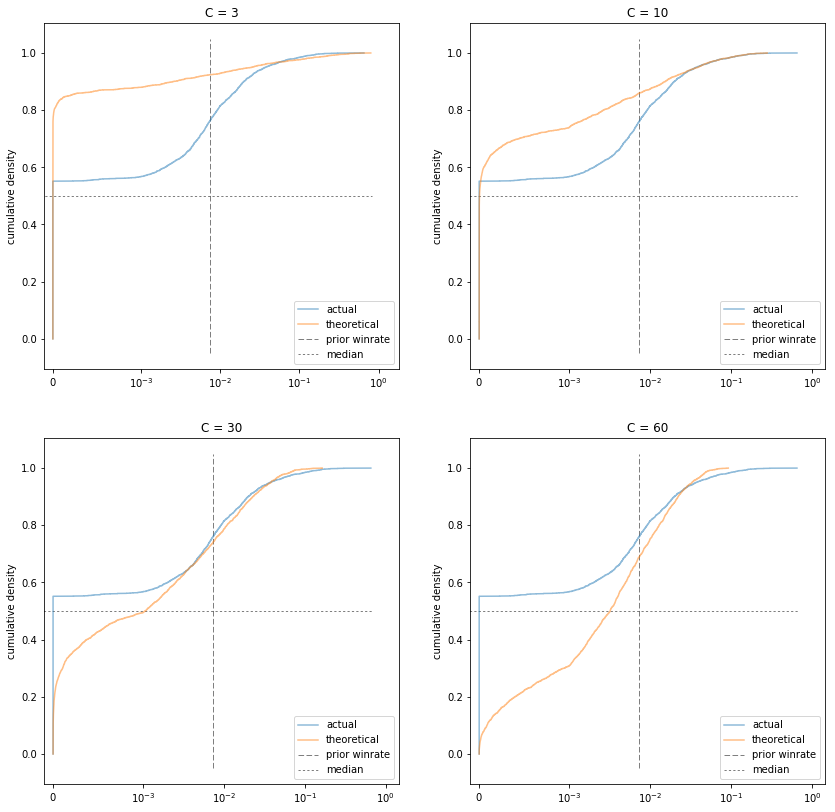

In [80]:
Cs = [3, 10, 30, 60]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
for (C, ax) in zip(Cs, axes.flatten()):
    ax = plot_winrates(C=C, ax=ax);
    xlin = 10**-3
    ax.set_xscale('symlog', linthreshx=xlin);
    ax.set_xlim(left=-10e-5);
    ax.set_title('C = {}'.format(C))
    ax.legend(loc=4);

C=30 certainly looks like the winner. The only problem is that it seems to assign too much weight to small non-zero probabilities, and slightly too little weight to high probabilities.

Or does it? Remember that the observed win rates are *not* actual samples from the distribution we're trying to model (the true win rates of DCSS players). They're noisy samples. The noisiness is mostly not a big deal, since we're only looking at players with at least 100 games.

*However*, if your true win rate is 1 in 1,000, or 1 in 10,000, then your win rate over 100 games will be a *very* noisy estimate of your true win rate. Our sample has a lot of players with 0% win rates. Lots of those players (all of them, if we invoke the [infinite monkey theorem](https://en.wikipedia.org/wiki/Infinite_monkey_theorem)) must have a small but non-zero chance of winning, but those win rates are very hard to measure. (The lowest observed win rate in the data is 1.2e-4, or about 1 in 10,000).

As for underestimating high win rates, I'm not too worried. It could be a real problem. It could be that sampling effects are also causing an overrepresentation of high win rates. It could be that high win rates are overrepresented among players with at least 100 games. But the discrepancy is not huge, and I'd rather be conservative about guessing a high win rate given a small number of games.

"Try a bunch of different parameter settings, graph some samples from the distribution under those parameters, and choose the one that looks the best" doesn't quite have the ring of scientific rigour to it, but it at least feels better than picking a number out of a hat. If you know of a better way to approach this problem, let me know!